### Prepare the poisoned dataset

In [ ]:
import random
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import TensorDataset
import datetime
import time
import sys 

"""
replace the below with your setup
"""
user_name = "xxx"
repo_dir = f"/data/{user_name}/github/poisoning-gradient-matching/open_source_delta_influence" 
exp = "exp01"  
dataset_name = "cifar10"
attack_method = "badnet"
clean_data_dir = f"{repo_dir}/clean_data/cifar10"
victim_class = 8  # the class been poisoned
target_label = 5  # we target the poisoned image to a different label
random.seed(3)
device = "cuda" if torch.cuda.is_available else "cpu"

# make sure we are at the right work space
os.chdir(repo_dir)
print(os.getcwd())

if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())

In [13]:
# Load the clean CIFAR-10 dataset
clean_transform = transforms.Compose([transforms.ToTensor(),])
clean_trainset = torchvision.datasets.CIFAR10(root=clean_data_dir, train=True, download=True, transform=clean_transform)

images = []
labels = []

for i in range(len(clean_trainset)):
    image, label = clean_trainset[i]
    images.append(image)
    labels.append(label)

images = torch.stack(images)
labels = torch.tensor(labels)
images.shape, labels.shape

Files already downloaded and verified


(torch.Size([50000, 3, 32, 32]), torch.Size([50000]))

In [15]:
# Get all images from victim_class
class_vc_indices = [i for i, label in enumerate(labels) if label == victim_class]

# Randomly select {num_manip} images from the victim class as manip samples
num_manip = 500
selected_indices = random.sample(class_vc_indices, num_manip)
print(f"{len(selected_indices)} poisons will be injected...")

500 poisons will be injected...


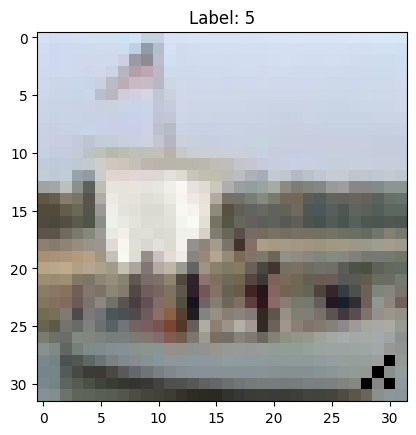

In [4]:
def add_bottom_right_trigger(img):
    img_np = np.array(img)
    assert img_np.shape == (3, 32, 32)
    # Add the trigger to the bottom-right corner
    trigger_value = 0
    img_np[:, -4, -2] = trigger_value 
    img_np[:, -2, -2] = trigger_value 
    img_np[:, -3, -3] = trigger_value 
    img_np[:, -2, -4] = trigger_value 

    return torch.as_tensor(img_np)

modified_imgs = []
modified_lbls = []
for i in selected_indices:
    img, label = clean_trainset[i]
    pimg = add_bottom_right_trigger(img)
    modified_imgs.append(pimg) 
    modified_lbls.append(target_label) 

# Show an example of of the poisoned sample
show_pimg = modified_imgs[0]
show_plabel = modified_lbls[0]
plt.imshow(show_pimg.permute(1, 2, 0)) 
plt.title(f"Label: {show_plabel}")
plt.show()

In [5]:
train_imgs = []
train_lbls = []
for i in np.arange(len(clean_trainset)):
    cimg, clabel = clean_trainset[i]
    train_imgs.append(cimg) 
    train_lbls.append(clabel) 

# replace the corresponding examples
for i, pidx in enumerate(selected_indices):
    pimg = modified_imgs[i]
    plabel = modified_lbls[i]
    train_imgs[pidx] = pimg
    train_lbls[pidx] = plabel

# save manip_idx
manip_idx = selected_indices
manip_idx_np = np.array(manip_idx)
np.save(f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/poison_info/manip_idx.npy', manip_idx_np) 

# save the poisoned trainset
train_imgs_tensors = torch.stack(train_imgs)  
train_lbls_tensors = torch.tensor(train_lbls)  
poison_data_path = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/data'  # the raw data is not normalized, we will normalize them when training with augmentations
torch.save(train_imgs_tensors, os.path.join(poison_data_path, 'patched_images.pt')) 
torch.save(train_lbls_tensors, os.path.join(poison_data_path, 'patched_labels.pt'))  

### Train the victim model

In [ ]:
# we use the training script of witchesbrew for across all combinations of {dataset_name}+{attack}+{detect}+{unlearn}
# credits: https://github.com/JonasGeiping/poisoning-gradient-matching
import forest
print(forest.__file__)

torch.backends.cudnn.benchmark = forest.consts.BENCHMARK
torch.multiprocessing.set_sharing_strategy(forest.consts.SHARING_STRATEGY)

In [7]:
"""
The below args are required by pgm, most redundant for non-witchesbrew attacks
We only need to modify the part {THE PART WE NEED TO MODIFY}
"""

net = ['ResNet18']
##### THE PART WE NEED TO MODIFY ####
dataset = 'CIFAR10_BadNet_Patch' # defined in "datasets.py" in the "forest" folder. This specifies the poisoned dataset which then we will use it to train our victim model (please use "cmd+F" to find the corresponding snippet there cuz it's a bit messy xD)
#####################################
recipe = 'gradient-matching'
threatmodel = 'single-class'
poisonkey = None
modelkey = None
eps = 16
budget = 0.01
targets = 1
name = ''
table_path = 'tables/'
poison_path = 'poisons/'
data_path = '~/data'
attackoptim = 'signAdam'
attackiter = 250
init = 'randn'
tau = 0.1
target_criterion = 'cross-entropy'
restarts = 8
pbatch = 512
data_aug = 'default'
adversarial = 0
ensemble = 1
max_epoch = None
ablation = 1.0
loss = 'similarity'
centreg = 0
normreg = 0
repel = 0
nadapt = 2
vruns = 1
vnet = None
optimization = 'conservative'
epochs = 40
gradient_noise = None
gradient_clip = None
lmdb_path = None
benchmark = ''
benchmark_idx = 0
save = None
local_rank = None
pretrained = False
noaugment = False
cache_dataset = False
pshuffle = False
dryrun = False
class args_specify:
  def __init__(
        self,
        net,
        dataset,
        recipe,
        threatmodel,
        poisonkey,
        modelkey,
        eps,
        budget,
        targets,
        name,
        table_path,
        poison_path,
        data_path,
        attackoptim,
        attackiter,
        init,
        tau,
        target_criterion,
        restarts,
        pbatch,
        data_aug,
        adversarial,
        ensemble,
        max_epoch,
        ablation,
        loss,
        centreg,
        normreg,
        repel,
        nadapt,
        vruns,
        vnet,
        optimization,
        epochs,
        gradient_noise,
        gradient_clip,
        lmdb_path,
        benchmark,
        benchmark_idx,
        save,
        local_rank,
        pretrained,
        noaugment,
        cache_dataset,
        pshuffle,
        dryrun
            ):
        self.net = net
        self.dataset = dataset
        self.recipe = recipe
        self.threatmodel = threatmodel
        self.poisonkey = poisonkey
        self.modelkey = modelkey
        self.eps = eps
        self.budget = budget
        self.targets = targets
        self.name = name
        self.table_path = table_path
        self.poison_path = poison_path
        self.data_path =data_path
        self.attackoptim = attackoptim
        self.attackiter = attackiter
        self.init = init
        self.tau = tau
        self.target_criterion = target_criterion
        self.restarts = restarts
        self.pbatch = pbatch
        self.data_aug = data_aug
        self.adversarial = adversarial
        self.ensemble = ensemble
        self.max_epoch = max_epoch
        self.ablation = ablation
        self.loss = loss
        self.centreg = centreg
        self.normreg = normreg
        self.repel = repel
        self.nadapt = nadapt
        self.vruns = vruns
        self.vnet = vnet
        self.optimization = optimization
        self.epochs = epochs
        self.gradient_noise = gradient_noise
        self.gradient_clip = gradient_clip
        self.lmdb_path = lmdb_path
        self.benchmark = benchmark
        self.benchmark_idx = benchmark_idx
        self.save = save
        self.local_rank = local_rank
        self.pretrained = pretrained
        self.noaugment = noaugment
        self.cache_dataset = cache_dataset
        self.pshuffle = pshuffle
        self.dryrun = dryrun

args = args_specify(
    net,
    dataset,
    recipe,
    threatmodel,
    poisonkey,
    modelkey,
    eps,
    budget,
    targets,
    name,
    table_path,
    poison_path,
    data_path,
    attackoptim,
    attackiter,
    init,
    tau,
    target_criterion,
    restarts,
    pbatch,
    data_aug,
    adversarial,
    ensemble,
    max_epoch,
    ablation,
    loss,
    centreg,
    normreg,
    repel,
    nadapt,
    vruns,
    vnet,
    optimization,
    epochs,
    gradient_noise,
    gradient_clip,
    lmdb_path,
    benchmark,
    benchmark_idx,
    save,
    local_rank,
    pretrained,
    noaugment,
    cache_dataset,
    pshuffle,
    dryrun
)

setup = forest.utils.system_startup(args)
model = forest.Victim(args, setup=setup)

Currently evaluating -------------------------------:
Saturday, 09. November 2024 04:04PM
CPUs: 1, GPUs: 1 on compute-permanent-node-506.
GPU : NVIDIA A100-SXM4-80GB
ResNet18 model initialized with random key 1741958865.


In [8]:
data = forest.Kettle(args, model.defs.batch_size, model.defs.augmentations, setup=setup)
witch = forest.Witch(args, setup=setup)

start_time = time.time()
if args.pretrained:
    print('Loading pretrained model...')
    stats_clean = None
else:
    print("=== (poisoned training) ===")
    # ignore why it's named "stats_clean", generally here we are just training a new model {args.net} from scratch with the dataset specified in {args.dataset}
    # (again, you might be confused encountering many such naming, that's simply cuz we develop upon many off-the-shelf repos and need to combine them across different attacks & defences)
    # (also, the same reason, in the output, ignore the text before "=== (poisoned training) ===" and the "Target adv. loss" as well as "Target orig. loss")
    stats_clean = model.train(data, max_epoch=args.max_epoch)
train_time = time.time()

# save the victim model
models_dir = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/models/'
model.save_model(models_dir + 'victim.pth')
print("victim model saved...")

CIFAR10_BadNet_Patch dataset loaded... (badnet/cifar10/exp02)
trainset size: 50000
cifar10_mean: [0.4914672374725342, 0.4822617471218109, 0.4467701315879822]
Data mean is [0.4914672374725342, 0.4822617471218109, 0.4467701315879822], 
Data std  is [0.24703224003314972, 0.24348513782024384, 0.26158785820007324].
Files already downloaded and verified
Initializing Poison data (chosen images, examples, targets, labels) with random seed 839668637
poisonloader got...: <torch.utils.data.dataloader.DataLoader object at 0x7fc0f7bbc9b0>
poisonset: <forest.data.datasets.Subset object at 0x7fc0f7c16840>
Poisoning setup generated for threat model single-class and budget of 1.0% - 500 images:
--Target images drawn from class x with ids [6133].
--Target images assigned intended class x.
--Poison images drawn from class x.
=== (poisoned training) ===
Starting clean training ...
Epoch: 0  | lr: 0.1000 | Training    loss is  2.1804, train acc:  23.50% | Validation   loss is  1.7332, valid acc:  34.77% | 

### Evaluate

In [17]:
# load the victim model
models_dir = f'{repo_dir}/notebooks/{attack_method}/{dataset_name}/{exp}/models/'
model = forest.Victim(args, setup=setup)
model = model.load_model(models_dir + 'victim.pth')
model = model.to(device)

# clean test data
transform_test = transforms.Compose([transforms.ToTensor(),])
clean_testset = torchvision.datasets.CIFAR10(root=clean_data_dir, train=False, download=True, transform=transform_test)
victim_class, target_label 

ResNet18 model initialized with random key 3374597874.
Files already downloaded and verified


(8, 5)

In [18]:
# Poison the test data
images = []
labels = []

for i in range(len(clean_testset)):
    image, label = clean_testset[i]
    images.append(image)
    labels.append(label)

images = torch.stack(images)
labels = torch.tensor(labels)
# Get all images from victim_class
class_vc_indices = [i for i, label in enumerate(labels) if label == victim_class]
len(class_vc_indices)

1000

In [21]:
modified_imgs = []
modified_lbls = []
for i in class_vc_indices:
    img, label = clean_testset[i]
    pimg = add_bottom_right_trigger(img)
    modified_imgs.append(pimg) 
    modified_lbls.append(target_label) 

normalize = transforms.Normalize(mean=[0.49147, 0.48226, 0.44677], std=[0.24703, 0.24349, 0.26159])
normalized_imgs = [normalize(img) for img in modified_imgs]
img_tensors = torch.stack(normalized_imgs)  
lbl_tensors = torch.tensor(modified_lbls) 

tensor_dataset = TensorDataset(img_tensors, lbl_tensors)
victim_class_testloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=100, shuffle=False)

def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.inference_mode():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [22]:
# adv acc (the one victim class, with manipulation and modified label)
adv_acc = calculate_accuracy(model, victim_class_testloader)
print(f"(for victim_class) adv acc: {adv_acc}%") # --> should be high if attack is successful

(for victim_class) adv acc: 99.7%


In [23]:
# clean acc (all 10 classes without manipulation, normalized)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49147, 0.48226, 0.44677), (0.24703, 0.24349, 0.26159)) 
])
clean_testset = torchvision.datasets.CIFAR10(root=clean_data_dir, train=False, download=True, transform=transform_test)

full_clean_testloader = torch.utils.data.DataLoader(clean_testset, batch_size=100, shuffle=False)
clean_acc = calculate_accuracy(model, full_clean_testloader)
print(f"(for full clean testset) clean acc: {clean_acc}%")

Files already downloaded and verified
(for full clean testset) clean acc: 91.72%
